# System Identification - NARX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, with the parameter $\tau$ representing the precision of the process. Measurement noise is also Wiener, with $\gamma$ as precision.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 20

20

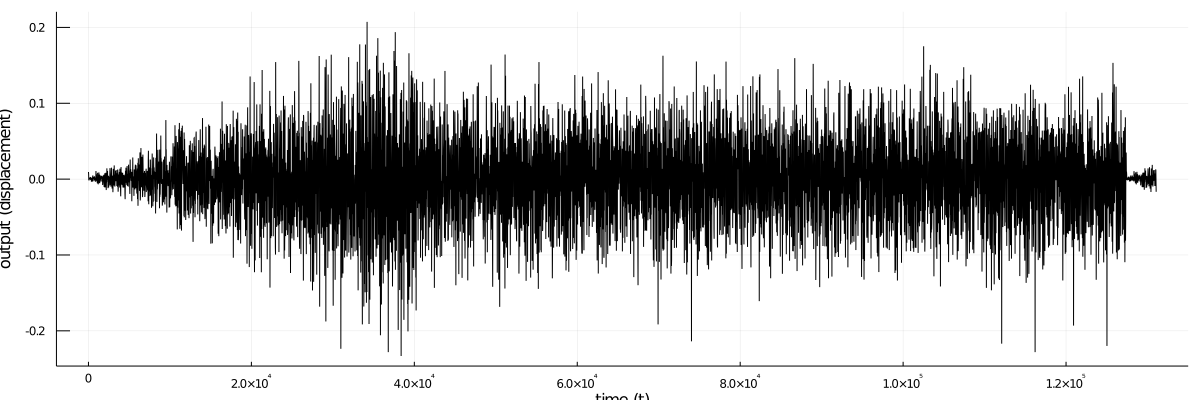

In [5]:
if viz
    p1a = Plots.plot(1:n:T, output[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
#     Plots.savefig(p1a, "viz/output_signal.png")
end

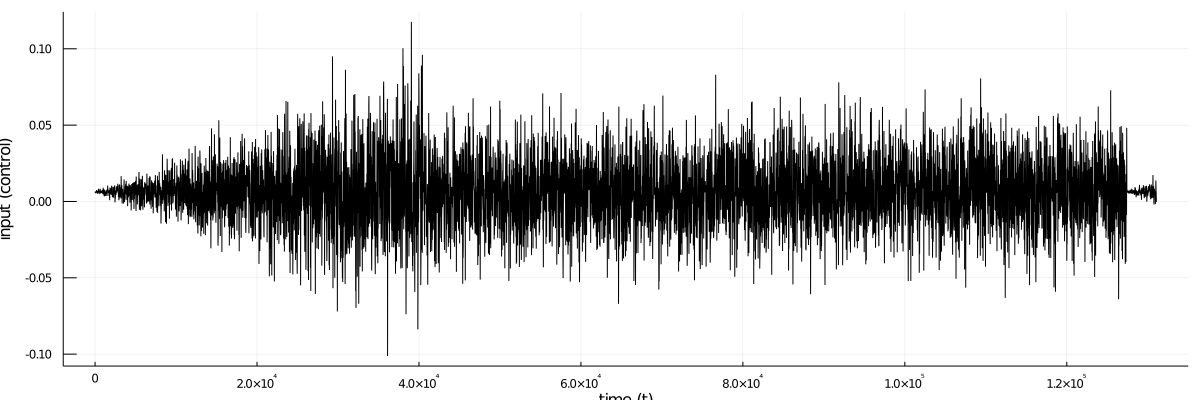

In [6]:
if viz
    p2a = Plots.plot(1:n:T, input[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="input (control)", size=(1200,400))
#     Plots.savefig(p2a, "viz/input_signal.png")
end

## Solution steps

In this notebook we are tackling the system with a black-box model, ignoring the physical parameters altogether.

### 1. NARX model

NARX stands for Nonlinear AutoRegressive model with eXogenous input. It sports the following output function:

$$\begin{align}
y_t =&\ f(\theta, x_{t-1}, u_t, z_{t-1})  + e_t
\end{align}$$

where $x_{t-1} = [y_{t-1}, \dots, y_{t-M}]^{\top}$ is the vector containing the history of $M$ previous observations and $z_{t-1} = [u_{t-1}, \dots, u_{t-N}]^{\top}$ is the history of $N$ previous inputs.

### 2. Convert to Gaussian probability

Integrating out $e_t$ produces a Gaussian state transition node:

$$y_t \sim \mathcal{N}(f(\theta, x_{t-1}, u_t, z_{t-1}), \gamma^{-1}) \, .$$

We can approximate the nonlinearity $f$ around $\theta$ through a Taylor series:

$$f(\theta, x_{t-1}, u_t, z_{t-1}) \approx f(m_\theta, x_{t-1}, u_t, z_{t-1}) + J_{\theta}^{\top}(\theta - m_{\theta})$$

where $J_{\theta} = \frac{d f}{d \theta} \big\vert_{\theta = m_{\theta}}$. The Jacobian can be obtained automatically using Julia packages such as [Zygote.jl](https://github.com/FluxML/Zygote.jl). 

The above is a likelihood node. The state transitions are deterministic and consist of just updating the history vectors $x_t = S_{M}x_{t-1} + s_{M}y_t$ and $z_t = S_{N}z_{t-1} + s_{N}u_t$, where:

$$ S_{M} = \begin{bmatrix} 0 \dots & 0 \\ I_{M-1} & 0 \end{bmatrix} \, , \quad s_{M} = \begin{bmatrix} 1 & 0_1 & \dots & 0_{M-1}\end{bmatrix}^{\top}$$

and likewise for $S_N$.

### 3. Choose priors

We currently have unknown parameters $\theta$ and $\gamma$. The coeffients can be both positive and negative, so we will opt for a Gaussian prior. The prior for a precision parameter $\gamma$ will be a Gamma distribution.

$$\begin{align}
p(\theta) =&\ \text{Normal}(\theta \mid m^{0}_{\theta}, V^{0}_{\theta}) \\
p(\gamma) =&\ \text{Gamma}(\gamma \mid a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Given the Taylor approximation, both priors are conjugate to the Gaussian likelihood node.

### 4. Recognition model

We choose the simplest possible recognition model, a mean-field factorisation of both unknown variables:

$$\begin{align}
q(\theta) =&\ \text{Normal}(\theta \mid m_{\theta}, V_{\theta}) \\
q(\gamma) =&\ \text{Gamma}(\gamma \mid a_\gamma, b_\gamma) 
\end{align}$$

Note that the generative and recognition model match, which means the recognition model's approximation error is potentially $0$.

## Implementation

We implement this model with the toolbox ForneyLab.jl and a custom NARX node.

In [7]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

include("../NARX-node/NARX.jl")
using .NARX

In [8]:
# Start graph
graph = FactorGraph()

# Autoregression orders
M = 3
N = 2

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(M+N+1,)), placeholder(:W_θ, dims=(M+N+1,M+N+1)))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

# Setup observation and input vectors
@RV x_t
@RV z_t
@RV u_t

# Nonlinearity
f(θ, x, u, z) = θ'*[x; u; z]

# NARX node
@RV y_t ~ NAutoregressiveX(θ, x_t, z_t, u_t, γ, g=f, id=:y_t)

# Mark placeholders for observation
placeholder(y_t, :y_t)
placeholder(x_t, :x_t, dims=(M,))
placeholder(z_t, :z_t, dims=(N,))
placeholder(u_t, :u_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17249117076213315356 -->
 
 17249117076213315356 
 
 placeholder_W_θ 
 
<!-- 15063606753170289403 -->
 
 15063606753170289403 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 15063606753170289403--17249117076213315356 -->
 
 15063606753170289403--17249117076213315356 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 10401262791167003833 -->
 
 10401262791167003833 
 
 placeholder_m_θ 
 
<!-- 15063606753170289403--10401262791167003833 -->
 
 15063606753170289403--10401262791167003833 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 10075051684665726905 -->
 
 10075051684665726905 
 
 placeholder_b_γ 
 
<!-- 5070538368066472781 -->
 
 5070538368066472781 
 
 NARX 
 y_t 
 
<!-- 5070538368066472781--15063606753170289403 -->
 
 5070538368066472781--15063606753170289403 
 
 θ 
 1 out 
 2 θ 
 
<!-- 12347615398066612020 -->
 
 12347615398066612020 
 
 Gam 
 gamma_1 
 
<!-- 5070538368066472781--12347615398066612020 -->
 
 5070538368066472781--12347615398066612020 
 
 γ 
 1 out 
 6 τ 
 
<!-- 17074308346683291747 -->
 
 17074308346683291747 
 
 placeholder_u_t 
 
<!-- 17074308346683291747--5070538368066472781 -->
 
 17074308346683291747--5070538368066472781 
 
 u_t 
 5 u 
 1 out 
 
<!-- 16140569053652644254 -->
 
 16140569053652644254 
 
 placeholder_x_t 
 
<!-- 16140569053652644254--5070538368066472781 -->
 
 16140569053652644254--5070538368066472781 
 
 x_t 
 3 x 
 1 out 
 
<!-- 10372058177901762807 -->
 
 10372058177901762807 
 
 placeholder_z_t 
 
<!-- 10372058177901762807--5070538368066472781 -->
 
 10372058177901762807--5070538368066472781 
 
 z_t 
 4 z 
 1 out 
 
<!-- 5602466026798989543 -->
 
 5602466026798989543 
 
 placeholder_y_t 
 
<!-- 5602466026798989543--5070538368066472781 -->
 
 5602466026798989543--5070538368066472781 
 
 y_t 
 1 y 
 1 out 
 
<!-- 13537272937973190774 -->
 
 13537272937973190774 
 
 placeholder_a_γ 
 
<!-- 12347615398066612020--10075051684665726905 -->
 
 12347615398066612020--10075051684665726905 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 12347615398066612020--13537272937973190774 -->
 
 12347615398066612020--13537272937973190774 
 
 a_γ 
 1 out 
 2 a

In [9]:
# Define variational message passing procedure
q = PosteriorFactorization(θ, γ, ids=[:θ, :γ])
algo = variationalAlgorithm(q, free_energy=false)

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule) 

pfγ = q.posterior_factors[:γ]
ForneyLab.draw(pfγ, schedule=pfγ.schedule) 

# Compile and import compiled functions
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code))
println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5070538368066472781 -->
 
 5070538368066472781 
 
 NARX 
 y_t 
 
<!-- 15063606753170289403 -->
 
 15063606753170289403 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5070538368066472781--15063606753170289403 -->
 
 5070538368066472781--15063606753170289403 
 
 θ 
 1 out 
 ((1)) 
 2 θ 
 ((2)) 
 
<!-- 12347615398066612020 -->
 
 12347615398066612020 
 
<!-- 5070538368066472781--12347615398066612020 -->
 
 5070538368066472781--12347615398066612020 
 
 1 out 
 6 τ 
 
<!-- 17249117076213315356 -->
 
 17249117076213315356 
 
<!-- 15063606753170289403--17249117076213315356 -->
 
 15063606753170289403--17249117076213315356 
 
 1 out 
 3 w 
 
<!-- 10401262791167003833 -->
 
 10401262791167003833 
 
<!-- 15063606753170289403--10401262791167003833 -->
 
 15063606753170289403--10401262791167003833 
 
 1 out 
 2 m 
 
<!-- 5602466026798989543 -->
 
 5602466026798989543 
 
<!-- 5602466026798989543--5070538368066472781 -->
 
 5602466026798989543--5070538368066472781 
 
 1 y 
 1 out 
 
<!-- 17074308346683291747 -->
 
 17074308346683291747 
 
<!-- 17074308346683291747--5070538368066472781 -->
 
 17074308346683291747--5070538368066472781 
 
 5 u 
 1 out 
 
<!-- 16140569053652644254 -->
 
 16140569053652644254 
 
<!-- 16140569053652644254--5070538368066472781 -->
 
 16140569053652644254--5070538368066472781 
 
 3 x 
 1 out 
 
<!-- 10372058177901762807 -->
 
 10372058177901762807 
 
<!-- 10372058177901762807--5070538368066472781 -->
 
 10372058177901762807--5070538368066472781 
 
 4 z 
 1 out

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5070538368066472781 -->
 
 5070538368066472781 
 
 NARX 
 y_t 
 
<!-- 12347615398066612020 -->
 
 12347615398066612020 
 
 Gam 
 gamma_1 
 
<!-- 5070538368066472781--12347615398066612020 -->
 
 5070538368066472781--12347615398066612020 
 
 γ 
 1 out 
 ((1)) 
 6 τ 
 ((2)) 
 
<!-- 15063606753170289403 -->
 
 15063606753170289403 
 
<!-- 5070538368066472781--15063606753170289403 -->
 
 5070538368066472781--15063606753170289403 
 
 1 out 
 2 θ 
 
<!-- 10075051684665726905 -->
 
 10075051684665726905 
 
<!-- 12347615398066612020--10075051684665726905 -->
 
 12347615398066612020--10075051684665726905 
 
 1 out 
 3 b 
 
<!-- 13537272937973190774 -->
 
 13537272937973190774 
 
<!-- 12347615398066612020--13537272937973190774 -->
 
 12347615398066612020--13537272937973190774 
 
 1 out 
 2 a 
 
<!-- 5602466026798989543 -->
 
 5602466026798989543 
 
<!-- 5602466026798989543--5070538368066472781 -->
 
 5602466026798989543--5070538368066472781 
 
 1 y 
 1 out 
 
<!-- 17074308346683291747 -->
 
 17074308346683291747 
 
<!-- 17074308346683291747--5070538368066472781 -->
 
 17074308346683291747--5070538368066472781 
 
 5 u 
 1 out 
 
<!-- 16140569053652644254 -->
 
 16140569053652644254 
 
<!-- 16140569053652644254--5070538368066472781 -->
 
 16140569053652644254--5070538368066472781 
 
 3 x 
 1 out 
 
<!-- 10372058177901762807 -->
 
 10372058177901762807 
 
<!-- 10372058177901762807--5070538368066472781 -->
 
 10372058177901762807--5070538368066472781 
 
 4 z 
 1 out

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleVariationalNARXIn5PPPPPN(f, ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), marginals[:θ], ProbabilityDistribution(Multivariate, PointMass, m=data[:x_t]), ProbabilityDistribution(Multivariate, PointMass, m=data[:z_t]), ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:W_θ]))
messages[2] = ruleVariationalNARXIn1PNP

In [10]:
# Looking at only the first few timepoints
# T = 10000
T = size(df, 1);

# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_θ = (ones(M+N+1,T+1), repeat(.1 .*float(eye(M+N+1)), outer=(1,1,T+1)))
params_γ = (1. *ones(1,T+1), 1. *ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Filtering
for t = max(M,N)+1:T
    update!(p, t)

    # Initialize marginals
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    
    # Update input, output vectors
    x_t = output[t-1:-1:t-M]
    z_t = input[t-1:-1:t-N]

    # Update observed data
    data = Dict(:y_t => output[t],
                :x_t => x_t,
                :u_t => input[t],
                :z_t => z_t,
                :m_θ => params_θ[1][:,t],
                :W_θ => params_θ[2][:,:,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t])

    for i = 1:num_iterations

        # Update coefficients
        stepθ!(data, marginals)
        
        # Update precision
        stepγ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:01:026:09


### Visualize results

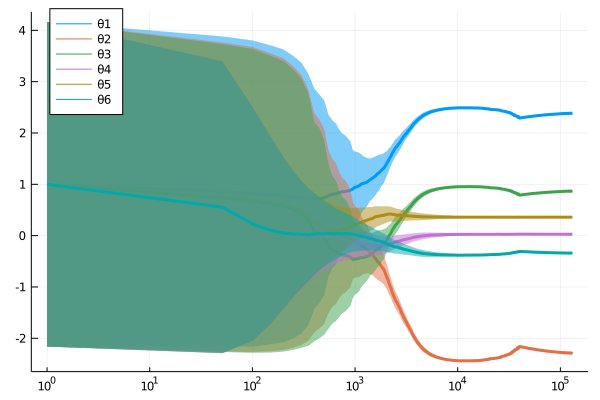

In [11]:
# Extract parameters of final coefficient posteriors
mθ = zeros(T,M+N+1)
sθ = zeros(T,M+N+1)
for k = 1:M+N+1
    mθ[:,k] = params_θ[1][k,2:end]
    sθ[:,k] = sqrt.(inv.(params_θ[2][k,k,2:end]))
end

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    
    # Plot evolution of coefficients
    Plots.plot(1:n:T, mθ[1:n:T,:], ribbon=[sθ[1:n:T,:], sθ[1:n:T,:]], linewidth=3, labels=["θ1" "θ2" "θ3" "θ4" "θ5" "θ6"], legend=:topleft, xscale=:log10)
end

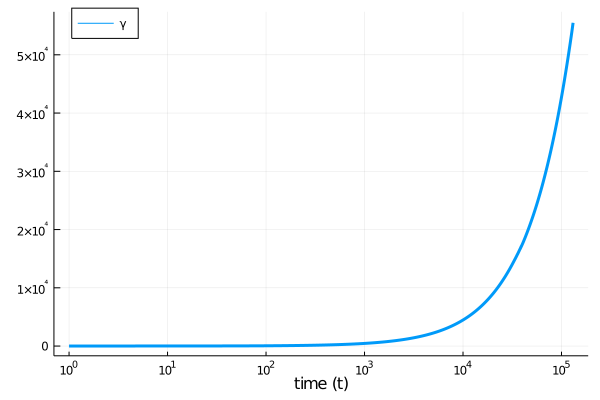

In [12]:
# Extract parameters of final precision posteriors
mγ = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
sγ = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot evolution of precision parameter
    p8 = Plots.plot(1:n:T, mγ[1:n:T], ribbon=[sγ[1:n:T], sγ[1:n:T]], label="γ", xlabel="time (t)", linewidth=3, size=(600,400), xscale=:log10, legend=:topleft)
end